## Import Dataset

In [ ]:
import pandas as pd

df = pd.read_csv('sector_returns.csv', delimiter=';', index_col=0)
df.index = pd.to_datetime(df.index.astype(str), format='%Y%m')
df = df / 100

print(df.head())

              Food    Beer   Smoke   Games   Books   Hshld   Clths    Hlth  \
1926-07-01  0.0056 -0.0519  0.0129  0.0293  0.1097 -0.0048  0.0808  0.0177   
1926-08-01  0.0259  0.2703  0.0650  0.0055  0.1001 -0.0358 -0.0251  0.0425   
1926-09-01  0.0116  0.0402  0.0126  0.0658 -0.0099  0.0073 -0.0051  0.0069   
1926-10-01 -0.0306 -0.0331  0.0106 -0.0476  0.0947 -0.0468  0.0012 -0.0057   
1926-11-01  0.0635  0.0729  0.0455  0.0166 -0.0580 -0.0054  0.0187  0.0542   

             Chems   Txtls  ...   Telcm   Servs   BusEq   Paper   Trans  \
1926-07-01  0.0814  0.0039  ...  0.0083  0.0922  0.0206  0.0770  0.0191   
1926-08-01  0.0550  0.0797  ...  0.0217  0.0202  0.0439 -0.0238  0.0485   
1926-09-01  0.0533  0.0230  ...  0.0241  0.0225  0.0019 -0.0554  0.0007   
1926-10-01 -0.0476  0.0100  ... -0.0011 -0.0200 -0.0109 -0.0508 -0.0261   
1926-11-01  0.0520  0.0310  ...  0.0163  0.0377  0.0364  0.0384  0.0161   

             Whlsl   Rtail   Meals     Fin   Other  
1926-07-01 -0.2379  0.0007 

## In Sample Analysis

### Mean Returns for Each Sectors (ri)

In [ ]:
expected_returns = df.mean().values  # Vector of sector average returns
print("Expected Returns (r_i):\n", expected_returns)

Expected Returns (r_i):
 [0.00945    0.01163274 0.01142335 0.01141387 0.00912809 0.00909831
 0.0090797  0.01065228 0.01024332 0.00940178 0.01012547 0.00956108
 0.01084679 0.01151438 0.01217411 0.01126734 0.00929408 0.01093638
 0.01028807 0.0087901  0.00826125 0.01238113 0.01209272 0.0097813
 0.00931717 0.00853308 0.01066438 0.01076768 0.01019628 0.00817335]


### Covariance Matrix (Σ)
Measures how sectors move together (critical for risk calculation).

In [ ]:
cov_matrix = df.cov().values  # Covariance matrix
print("Covariance Matrix:\n", cov_matrix)

Covariance Matrix:
 [[0.00220347 0.00233363 0.00180375 0.00288002 0.00243451 0.00215032
  0.00185664 0.00198844 0.00218249 0.00246036 0.00249457 0.00254314
  0.00241683 0.00261851 0.00244008 0.00249536 0.00175655 0.00251063
  0.00176207 0.00181111 0.00141318 0.00161522 0.00198009 0.00208528
  0.00234926 0.00234834 0.00219694 0.00220143 0.00252094 0.00224575]
 [0.00233363 0.00497274 0.0018732  0.00395503 0.00297735 0.00267368
  0.00220681 0.00247199 0.00273267 0.00330447 0.00332252 0.00320937
  0.00314074 0.00326743 0.00312452 0.00327309 0.00232012 0.00323531
  0.00218787 0.00222216 0.00165093 0.00200396 0.00251324 0.00255032
  0.00302131 0.00338101 0.00268817 0.00288583 0.00316094 0.00292994]
 [0.00180375 0.0018732  0.0033917  0.00248135 0.00202144 0.00183803
  0.00156505 0.00177688 0.00185696 0.00206072 0.00215762 0.00228172
  0.00205154 0.00220418 0.00205736 0.00213436 0.00163433 0.00224393
  0.00158401 0.0016219  0.00127581 0.00139139 0.0017022  0.00184304
  0.00200076 0.00204463 0.

### Target Expected Return

*   Set one return (average return across assets) and use that for every strategy at time 𝑡 to compare strategies fairly, since all aim for the same return.
*   This isolates the impact of the strategy constraints (e.g., no shorting, minimum investment) on risk and realized returns.

In [ ]:
# Compute target expected return: average of all r_i
target_return = expected_returns.mean()
print("Target Portfolio Return (r̄) Monthly:", target_return)

# Convert monthly return to annual return with compounding
annual_target_return = (1 + target_return)**12 - 1
print("Target Portfolio Return (r̄) Annual:", annual_target_return)

Target Portfolio Return (r̄) Monthly: 0.010216319796954317
Target Portfolio Return (r̄) Annual: 0.12972453790930794


### MV – the unconstrained optimal mean-variance strategy

In [ ]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd

N = len(expected_returns)
T = len(df) - 1  # Because we’ll compute t+1 returns

# Optimization setup
def portfolio_variance(w, cov_matrix):
    return 0.5 * np.dot(w.T, np.dot(cov_matrix, w))

# Constraints: target return and sum to 1
constraints = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
    {'type': 'eq', 'fun': lambda w: np.dot(w, expected_returns) - target_return}
]

bounds = [(None, None)] * N
w0 = np.ones(N) / N

# Store rolling results
weights_list = []
realized_returns = []

for t in range(T):
    # Solve optimization at time t (using fixed expected_returns and cov_matrix)
    result = minimize(portfolio_variance, w0, args=(cov_matrix,), method='SLSQP',
                      constraints=constraints, bounds=bounds)
    w_t = result.x
    weights_list.append(w_t)

    # Compute realized return at t+1 using actual data
    r_tp1 = df.iloc[t + 1].values  # returns at time t+1
    realized_return = np.dot(w_t, r_tp1)
    realized_returns.append(realized_return)

# Convert results to arrays and dataframe
realized_returns = np.array(realized_returns)
weights_array = np.array(weights_list)
mv_weights_in = pd.DataFrame(weights_array, columns=df.columns)

# Evaluation metrics
mv_returns_in = realized_returns

# Display results
print("In-Sample Evaluation (MV Strategy):")
print("Average Realized Return:", np.mean(mv_returns_in))
print("Portfolio Variance:", np.var(mv_returns_in, ddof=1))
print("Portfolio Risk/Volatility (Std Dev):", np.std(mv_returns_in, ddof=1))


In-Sample Evaluation (MV Strategy):
Average Realized Return: 0.010194005138661996
Portfolio Variance: 0.0014270916581411277
Portfolio Risk/Volatility (Std Dev): 0.03777686670624137


### NSMV – the optimal mean-variance strategy with no-shorting constraint

In [ ]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd

# Objective function: minimize portfolio variance
def portfolio_variance(w, cov_matrix):
    return 0.5 * np.dot(w.T, np.dot(cov_matrix, w))

# Constraints: target return and sum to 1
constraints = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
    {'type': 'eq', 'fun': lambda w: np.dot(w, expected_returns) - target_return}
]

# No shorting: weights must be >= 0
bounds = [(0, 1)] * N
w0 = np.ones(N) / N  # initial guess

# Store rolling weights and realized returns
weights_list = []
realized_returns = []

for t in range(len(df) - 1):
    # Optimize using fixed expected_returns and cov_matrix
    result = minimize(portfolio_variance, w0, args=(cov_matrix,), method='SLSQP',
                      constraints=constraints, bounds=bounds)
    w_t = result.x
    weights_list.append(w_t)

    # Realized return in t+1 using actual returns
    r_tp1 = df.iloc[t + 1].values
    realized_return = np.dot(w_t, r_tp1)
    realized_returns.append(realized_return)

# Convert to arrays and dataframe
realized_returns = np.array(realized_returns)
weights_array = np.array(weights_list)
nsmv_weights_in = pd.DataFrame(weights_array, columns=df.columns)


# Evaluation metrics
nsmv_returns_in = realized_returns

# Display results
print("In-Sample Evaluation (NSMV Strategy):")
print("Average Realized Return:", np.mean(nsmv_returns_in))
print("Portfolio Variance:", np.var(nsmv_returns_in, ddof=1))
print("Portfolio Risk/Volatility (Std Dev):", np.std(nsmv_returns_in, ddof=1))


In-Sample Evaluation (NSMV Strategy):
Average Realized Return: 0.010205523491724476
Portfolio Variance: 0.0019167016833137756
Portfolio Risk/Volatility (Std Dev): 0.043780151705010976


### MIMV – the optimal mean-variance strategy with the constraint that the minimal investment in each asset is 1/2N

In [ ]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd

# Objective: minimize portfolio variance
def portfolio_variance(w, cov_matrix):
    return 0.5 * np.dot(w.T, np.dot(cov_matrix, w))

# Constraints: target return and sum to 1
constraints = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
    {'type': 'eq', 'fun': lambda w: np.dot(w, expected_returns) - target_return}
]

# MIMV minimum weight constraint
min_weight = 1 / (2 * N)

# Bounds: all weights ≥ 1/(2N)
bounds = [(min_weight, 1) for _ in range(N)]
w0 = np.ones(N) / N  # Initial guess (equal-weighted)

# Store weights and realized returns
weights_list = []
realized_returns = []

for t in range(len(df) - 1):
    # Optimization using full-sample estimates (in-sample)
    result = minimize(portfolio_variance, w0, args=(cov_matrix,), method='SLSQP',
                      constraints=constraints, bounds=bounds)
    w_t = result.x
    weights_list.append(w_t)

    # Realized return at t+1
    r_tp1 = df.iloc[t + 1].values
    realized_return = np.dot(w_t, r_tp1)
    realized_returns.append(realized_return)

# Convert results to arrays and dataframe
realized_returns = np.array(realized_returns)
weights_array = np.array(weights_list)
mimv_weights_in = pd.DataFrame(weights_array, columns=df.columns)

# Evaluation
mimv_returns_in = realized_returns

# Display results
print("In-Sample Evaluation (MIMV Strategy):")
print("Average Realized Return:", np.mean(mimv_returns_in))
print("Portfolio Variance:", np.var(mimv_returns_in, ddof=1))
print("Portfolio Risk/Volatility (Std Dev):", np.std(mimv_returns_in, ddof=1))


In-Sample Evaluation (MIMV Strategy):
Average Realized Return: 0.010203297770168516
Portfolio Variance: 0.0023370191534349493
Portfolio Risk/Volatility (Std Dev): 0.04834272596197849


## Out-of-Sample Evaluation

### MV (Out-of-Sample, Rolling Window = 120)

In [ ]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd

M = 120
N = df.shape[1]

# Optimization function
def portfolio_variance(w, cov_matrix):
    return 0.5 * np.dot(w.T, np.dot(cov_matrix, w))

# Unconstrained optimal mean-variance strategy (MV allows negative weights, so no bounds)
bounds = [(None, None)] * N

# Output storage
weights_list = []
realized_returns = []

for t in range(M, len(df) - 1):
    # Get rolling window data
    window_data = df.iloc[t - M:t]
    mu_t = window_data.mean().values
    sigma_t = window_data.cov().values

    # Constraints: target return and sum to 1
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.dot(w, mu_t) - target_return}
    ]

    w0 = np.ones(N) / N  # Initial guess

    # Solve optimization
    result = minimize(portfolio_variance, w0, args=(sigma_t,), method='SLSQP',
                      constraints=constraints, bounds=bounds)

    w_t = result.x
    weights_list.append(w_t)

    # Apply weights to next month's actual return
    r_tp1 = df.iloc[t + 1].values
    realized_return = np.dot(w_t, r_tp1)
    realized_returns.append(realized_return)

# Convert to arrays and dataframe
realized_returns = np.array(realized_returns)
weights_array = np.array(weights_list)
mv_weights_out = pd.DataFrame(weights_array, columns=df.columns)


# Evaluate performance
mv_returns_out = realized_returns

# Print results
print("Out-of-Sample Evaluation (MV Strategy):")
print("Average Realized Return:", np.mean(mv_returns_out))
print("Portfolio Variance:", np.var(mv_returns_out, ddof=1))
print("Portfolio Risk/Volatility (Std Dev):", np.std(mv_returns_out, ddof=1))


Out-of-Sample Evaluation (MV Strategy):
Average Realized Return: 0.008574177121505601
Portfolio Variance: 0.00131105781154967
Portfolio Risk/Volatility (Std Dev): 0.03620853230316951


### NSMV (Out-of-Sample, Rolling Window = 120)

In [ ]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd

M = 120
N = df.shape[1]

# Optimization function
def portfolio_variance(w, cov_matrix):
    return 0.5 * np.dot(w.T, np.dot(cov_matrix, w))

# No-shorting constraint
bounds = [(0, 1)] * N

# Output storage
weights_list = []
realized_returns = []

for t in range(M, len(df) - 1):
    # Get rolling window data
    window_data = df.iloc[t - M:t]
    mu_t = window_data.mean().values
    sigma_t = window_data.cov().values

    # Constraints: target return and sum to 1
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.dot(w, mu_t) - target_return}
    ]

    w0 = np.ones(N) / N  # Initial guess

    # Solve optimization
    result = minimize(portfolio_variance, w0, args=(sigma_t,), method='SLSQP',
                      constraints=constraints, bounds=bounds)

    w_t = result.x
    weights_list.append(w_t)

    # Apply weights to next month's actual return
    r_tp1 = df.iloc[t + 1].values
    realized_return = np.dot(w_t, r_tp1)
    realized_returns.append(realized_return)

# Convert to arrays and dataframe
realized_returns = np.array(realized_returns)
weights_array = np.array(weights_list)
nsmv_weights_out = pd.DataFrame(weights_array, columns=df.columns)

# Evaluate performance
nsmv_returns_out = realized_returns

# Print results
print("Out-of-Sample Evaluation (NSMV Strategy):")
print("Average Realized Return:", np.mean(nsmv_returns_out))
print("Portfolio Variance:", np.var(nsmv_returns_out, ddof=1))
print("Portfolio Risk/Volatility (Std Dev):", np.std(nsmv_returns_out, ddof=1))


Out-of-Sample Evaluation (NSMV Strategy):
Average Realized Return: 0.009496793439758545
Portfolio Variance: 0.0016672530890461186
Portfolio Risk/Volatility (Std Dev): 0.040832010592745965


### MIMV (Out-of-Sample, Rolling Window = 120)

In [ ]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd

M = 120
N = df.shape[1]

# Optimization function
def portfolio_variance(w, cov_matrix):
    return 0.5 * np.dot(w.T, np.dot(cov_matrix, w))

# MIMV minimum weight constraint
min_weight = 1 / (2 * N)
bounds = [(min_weight, 1) for _ in range(N)]

# Output storage
weights_list = []
realized_returns = []

for t in range(M, len(df) - 1):
    # Get rolling window data
    window_data = df.iloc[t - M:t]
    mu_t = window_data.mean().values
    sigma_t = window_data.cov().values

    # Constraints: target return and sum to 1
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.dot(w, mu_t) - target_return}
    ]

    w0 = np.ones(N) / N  # Initial guess

    # Solve optimization
    result = minimize(portfolio_variance, w0, args=(sigma_t,), method='SLSQP',
                      constraints=constraints, bounds=bounds)

    w_t = result.x
    weights_list.append(w_t)

    # Apply weights to next month's actual return
    r_tp1 = df.iloc[t + 1].values
    realized_return = np.dot(w_t, r_tp1)
    realized_returns.append(realized_return)

# Convert to arrays and dataframe
realized_returns = np.array(realized_returns)
weights_array = np.array(weights_list)
mimv_weights_out = pd.DataFrame(weights_array, columns=df.columns)

# Evaluate performance
mimv_returns_out = realized_returns

# Print results
print("Out-of-Sample Evaluation (MIMV Strategy):")
print("Average Realized Return:", np.mean(mimv_returns_out))
print("Portfolio Variance:", np.var(mimv_returns_out, ddof=1))
print("Portfolio Risk/Volatility (Std Dev):", np.std(mimv_returns_out, ddof=1))


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


Out-of-Sample Evaluation (MIMV Strategy):
Average Realized Return: 0.009662279343528122
Portfolio Variance: 0.002148589087544334
Portfolio Risk/Volatility (Std Dev): 0.046352875720329735


## Evaluation

### Mean-Variance Table

In [ ]:
import pandas as pd
import numpy as np

# Dictionary of strategy return series
returns_dict = {
    "MV": mv_returns_in,
    "NSMV": nsmv_returns_in,
    "MIMV": mimv_returns_in,
    "MV (OOS)": mv_returns_out,
    "NSMV (OOS)": nsmv_returns_out,
    "MIMV (OOS)": mimv_returns_out
}

# Compute mean and variance for each strategy
results = {
    "Strategy": [],
    "Mean": [],
    "Variance": []
}

for name, returns in returns_dict.items():
    returns = np.array(returns)
    results["Strategy"].append(name)
    results["Mean"].append(np.mean(returns))
    results["Variance"].append(np.var(returns, ddof=1))  # sample variance

# Create DataFrame
mean_variance_df = pd.DataFrame(results)
mean_variance_df = mean_variance_df.round(4)

# Display
print("Mean-Variance Table (Monthly)")
print(mean_variance_df)

Mean-Variance Table (Monthly)
     Strategy    Mean  Variance
0          MV  0.0102    0.0014
1        NSMV  0.0102    0.0019
2        MIMV  0.0102    0.0023
3    MV (OOS)  0.0086    0.0013
4  NSMV (OOS)  0.0095    0.0017
5  MIMV (OOS)  0.0097    0.0021


### Mean-Standard Deviation Diagram

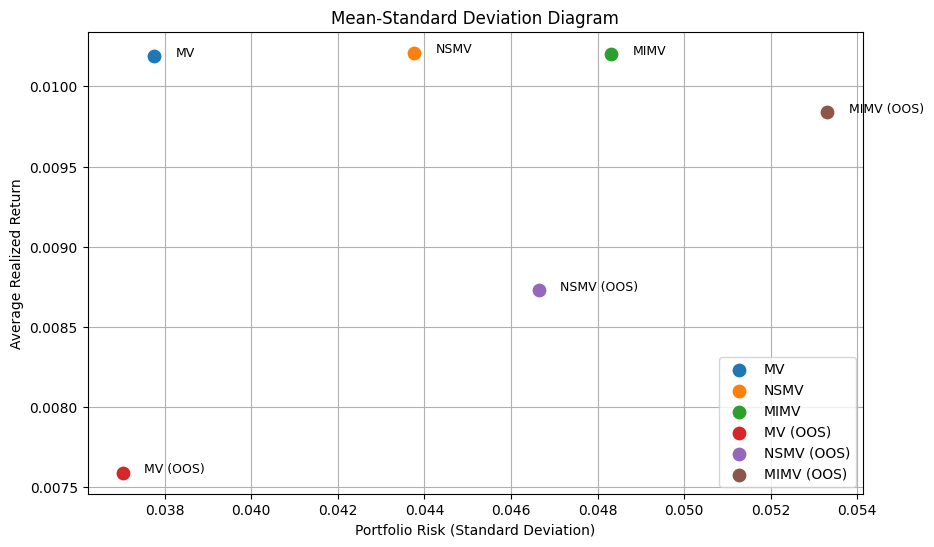

In [ ]:
import matplotlib.pyplot as plt

strategies = ["MV", "NSMV", "MIMV", "MV (OOS)", "NSMV (OOS)", "MIMV (OOS)"]
mean_returns = [0.01019, 0.01021, 0.01020, 0.00759, 0.00873, 0.00984]
std_devs = [0.03776, 0.04376, 0.04832, 0.03703, 0.04664, 0.05331]

plt.figure(figsize=(10, 6))

# Plot each point
for i in range(len(strategies)):
    plt.scatter(std_devs[i], mean_returns[i], label=strategies[i], s=80)
    plt.text(std_devs[i] + 0.0005, mean_returns[i], strategies[i], fontsize=9)

# Add labels and grid
plt.title("Mean-Standard Deviation Diagram")
plt.xlabel("Portfolio Risk (Standard Deviation)")
plt.ylabel("Average Realized Return")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Build dictionary of in- and out-of-sample return series
strategy_pairs = {
    "MV": (mv_returns_in, mv_returns_out),
    "NSMV": (nsmv_returns_in, nsmv_returns_out),
    "MIMV": (mimv_returns_in, mimv_returns_out)
}

# Calculate gaps
gap_data = {
    "Strategy": [],
    "In-Sample Mean": [],
    "Out-Sample Mean": [],
    "Return Gap": [],
    "In-Sample Sharpe": [],
    "Out-Sample Sharpe": [],
    "Sharpe Gap": []
}

# Risk-free monthly (3% annual)
rf_monthly = (1 + 0.03)**(1/12) - 1

for name, (r_in, r_out) in strategy_pairs.items():
    mean_in = np.mean(r_in)
    mean_out = np.mean(r_out)
    std_in = np.std(r_in, ddof=1)
    std_out = np.std(r_out, ddof=1)

    sharpe_in = (mean_in - rf_monthly) / std_in
    sharpe_out = (mean_out - rf_monthly) / std_out

    gap_data["Strategy"].append(name)
    gap_data["In-Sample Mean"].append(mean_in)
    gap_data["Out-Sample Mean"].append(mean_out)
    gap_data["Return Gap"].append(mean_in - mean_out)
    gap_data["In-Sample Sharpe"].append(sharpe_in)
    gap_data["Out-Sample Sharpe"].append(sharpe_out)
    gap_data["Sharpe Gap"].append(sharpe_in - sharpe_out)

# Convert to DataFrame
gap_df = pd.DataFrame(gap_data).round(4)

# Display
print("Out-of-Sample Gap Analysis")
print(gap_df)


Out-of-Sample Gap Analysis
  Strategy  In-Sample Mean  Out-Sample Mean  Return Gap  In-Sample Sharpe  \
0       MV          0.0102           0.0086      0.0016            0.2046   
1     NSMV          0.0102           0.0095      0.0007            0.1768   
2     MIMV          0.0102           0.0097      0.0005            0.1600   

   Out-Sample Sharpe  Sharpe Gap  
0             0.1687      0.0359  
1             0.1722      0.0046  
2             0.1552      0.0048  
